# Tie Rod Force Analysis

### Overview

This data was collected during a test day on [insert test day here]. The main purpose of the test was to observe the forces exerted on the tie rod during aggressive turns. The tie rod is a critical component in the steering mechanism, and understanding the forces it experiences is essential for ensuring the safety and performance of the vehicle.

### Data Collection

The data was collected using strain gauges attached to the tie rod. The strain gauges measure the deformation of the tie rod, which can be used to calculate the forces acting on it. The data was recorded at 100 Hz to capture the dynamic behavior of the tie rod during aggressive maneuvers.

### Data Analysis

The following sections provide a detailed analysis of the collected data. Each cell in the analysis is explained in detail, including the mathematical operations performed and the significance of the visualizations.


In [551]:
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and Clean Data

The `load_and_clean_data` function reads the data from a CSV file and cleans it by removing rows with invalid values. It also adds a `Time` column to the DataFrame to represent the time index of each data point.

## Data Cleaning and Preparation

In this section, we define a function `load_and_clean_data` that is responsible for loading the raw data from a CSV file and performing necessary cleaning operations. The function reads the data into a pandas DataFrame and adds a `Time` column to represent the time index of each data point.

The data cleaning process involves filtering the DataFrame to remove rows with invalid or irrelevant values. Specifically, we:
- Remove rows where the engine speed (`S8 RPM`) is below 2000, as these data points are not relevant for our analysis.
- Remove rows where the absolute value of inline acceleration (`InlineAcc`) is less than 0.2, as these data points indicate low dynamic activity.
- Remove statistical outliers in the `TieRodForce` column by excluding values that are more than three standard deviations away from the mean.

The cleaned DataFrame, `moving_df`, is then returned for further analysis. This step ensures that the data we analyze is relevant and free from noise, improving the accuracy and reliability of our subsequent analyses.

In [552]:
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)

    df['Time'] = np.arange(0, len(df) * 0.01, 0.01)

    moving_df = df[
        (df['S8 RPM'] > 2000) &
        (df['InlineAcc'].abs() > 0.2) &
        (df['TieRodForce'].abs() < df['TieRodForce'].std() * 3)  # Remove statistical outliers
        ].copy()
    return moving_df

## Analyze Tie Rod Forces

The `analyze_tie_rod_forces` function is designed to provide a comprehensive analysis of the tie rod forces, which is essential for several reasons:

> - **Safety and Performance**: Understanding the forces acting on the tie rod is crucial for ensuring the safety and performance of the vehicle. By identifying the maximum and minimum forces, we can assess whether the tie rod is operating within safe limits.
> - **Correlation Analysis**: The correlation coefficient helps in understanding how closely the tie rod forces are related to lateral acceleration. A strong correlation indicates that lateral acceleration is a significant factor influencing tie rod forces.
> - **Event Context**: By examining the context around extreme force events, we can gain insights into the driving conditions and maneuvers that lead to these peaks. This information is valuable for improving vehicle design and driving strategies.
> - **Trend Visualization**: The regression line provides a clear visualization of the relationship between tie rod forces and lateral acceleration, making it easier to interpret the data and identify trends.

1. **Correlation Calculation**: 
    - The function calculates the correlation coefficient between the tie rod forces (`TieRodForce`) and lateral acceleration (`LateralAcc`). This coefficient quantifies the strength and direction of the linear relationship between these two variables.

2. **Maximum and Minimum Force Events**:
    - The function identifies the maximum and minimum tie rod force values in the dataset. These extreme values are critical for understanding the peak loads experienced by the tie rod.
    - It also extracts the context around these events by selecting a window of data points (10 points before and after the event) to provide a detailed view of the conditions leading up to and following these extreme forces.

3. **Regression Line Calculation**:
    - The function calculates the slope and intercept of the regression line that best fits the relationship between tie rod forces and lateral acceleration. This regression line helps in visualizing the trend and making predictions based on the observed data.

Overall, this function is a key component of our data analysis workflow, providing valuable insights into the behavior of the tie rod under different driving conditions.


In [553]:
def analyze_tie_rod_forces(df, context_length=10):
    correlation = df['TieRodForce'].corr(df['LateralAcc'])

    max_force = df['TieRodForce'].max()
    min_force = df['TieRodForce'].min()

    max_idx = df['TieRodForce'].idxmax()
    min_idx = df['TieRodForce'].idxmin()

    max_context = df.loc[max_idx-context_length:max_idx+context_length,
                  ['Time', 'TieRodForce', 'LateralAcc', 'InlineAcc', 'S8 RPM']]
    min_context = df.loc[min_idx-context_length:min_idx+context_length,
                  ['Time', 'TieRodForce', 'LateralAcc', 'InlineAcc', 'S8 RPM']]

    slope, intercept = np.polyfit(df['LateralAcc'], df['TieRodForce'], 1)

    return {
        'correlation': correlation,
        'max_force': max_force,
        'min_force': min_force,
        'max_context': max_context,
        'min_context': min_context,
        'regression': {'slope': slope, 'intercept': intercept}
    }

## Plot Force Analysis

The `force_analysis` function visualizes the maximum and minimum tie rod force events along with the corresponding lateral acceleration values.

1. **Maximum Force Event Analysis**:
    - The function first plots the tie rod force over time for the maximum force event. This helps in understanding the behavior of the tie rod during the peak force event.
    - A twin axis is used to plot the lateral acceleration on the same graph, allowing for a direct comparison between the tie rod force and lateral acceleration.

2. **Minimum Force Event Analysis**:
    - Similarly, the function plots the tie rod force over time for the minimum force event. This helps in understanding the behavior of the tie rod during the lowest force event.
    - A twin axis is used to plot the lateral acceleration on the same graph, allowing for a direct comparison between the tie rod force and lateral acceleration.

Overall, this function provides a comprehensive visualization of the tie rod force events, allowing for a detailed analysis of the conditions leading up to and following the peak force events. This information is valuable for understanding the dynamic behavior of the tie rod and its interaction with lateral acceleration during aggressive maneuvers.

In [554]:
def force_analysis(max_context, min_context):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    ax1.set_title('Maximum Force Event Analysis', fontsize=12, pad=20)
    ax1.plot(max_context['Time'], max_context['TieRodForce'],
                      label='Tie Rod Force', color='white', linewidth=2)

    ax1_twin = ax1.twinx()
    ax1_twin.plot(max_context['Time'], max_context['LateralAcc'],
                           label='Lateral Acceleration', color='red', linestyle='--', linewidth=2)

    max_point = max_context['TieRodForce'].max()
    max_time = max_context.loc[max_context['TieRodForce'].idxmax(), 'Time']
    ax1.annotate(f'Max: {max_point:.2f} N',
                 xy=(max_time, max_point),
                 xytext=(10, 10), textcoords='offset points')

    ax2.set_title('Minimum Force Event Analysis', fontsize=12, pad=20)
    ax2.plot(min_context['Time'], min_context['TieRodForce'],
             label='Tie Rod Force', color='white', linewidth=2)

    ax2_twin = ax2.twinx()
    ax2_twin.plot(min_context['Time'], min_context['LateralAcc'],
                  label='Lateral Acceleration', color='red', linestyle='--', linewidth=2)

    min_point = min_context['TieRodForce'].min()
    min_time = min_context.loc[min_context['TieRodForce'].idxmin(), 'Time']
    ax2.annotate(f'Min: {min_point:.2f} N',
                 xy=(min_time, min_point),
                 xytext=(10, 10), textcoords='offset points')

    for ax in [ax1, ax2]:
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel('Force (N)', color='white', fontsize=10)
        ax.tick_params(axis='y', labelcolor='white')
        ax.grid(True, alpha=0.3)

    for ax in [ax1_twin, ax2_twin]:
        ax.set_ylabel('Lateral Acceleration (g)', color='red', fontsize=10)
        ax.tick_params(axis='y', labelcolor='red')

    for ax, ax_twin in [(ax1, ax1_twin), (ax2, ax2_twin)]:
        lines = ax.get_lines() + ax_twin.get_lines()
        labels = [line.get_label() for line in lines]
        ax.legend(lines, labels, loc='upper right')

    plt.tight_layout()
    return fig

## Histogram of Tie Rod Forces

The `force_histogram` function is designed to provide a visual representation of the distribution of absolute tie rod forces in the dataset. This histogram helps in understanding the frequency and magnitude of forces experienced by the tie rod during the test.

1. **Visualization of Force Distribution**:
    - The histogram provides a clear visual representation of how often different magnitudes of tie rod forces occur. This is crucial for identifying common force ranges and understanding the overall behavior of the tie rod under various conditions.

2. **Mean and Median Values**:
    - By displaying the mean and median values on the histogram, we can quickly assess the central tendency of the tie rod forces. The mean gives an average value, while the median provides the middle value, which is less affected by outliers. These metrics are important for summarizing the data and identifying typical force levels.

Overall, this function is a key component of the data analysis workflow, providing valuable insights into the distribution and central tendency of tie rod forces. Understanding these aspects is essential for assessing the performance and safety of the tie rod under different driving conditions.

In [555]:
def force_histogram(df):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    abs_forces = df['TieRodForce'].abs()

    # 10
    max_force = abs_forces.max()
    bin_edges = np.arange(0, max_force + 10, 10)

    plt.hist(abs_forces, bins=bin_edges,
             color='#00ffff',
             edgecolor='#ffffff',
             alpha=0.7)

    plt.xlabel('Absolute Tie Rod Force', fontsize=12, color='#ffffff')
    plt.ylabel('Frequency', fontsize=12, color='#ffffff')
    plt.title('Distribution of Absolute Tie Rod Forces',
              fontsize=14, pad=20, color='#ffffff')

    plt.grid(True, alpha=0.3, color='#888888')

    mean_force = abs_forces.mean()
    median_force = abs_forces.median()

    plt.axvline(mean_force, color='#ff4444',
                linewidth=2,
                linestyle='--',
                label=f'Mean: {mean_force:.2f}')
    plt.axvline(median_force, color='#44ff44',
                linewidth=2,
                linestyle='--',
                label=f'Median: {median_force:.2f}')

    legend = plt.legend(facecolor='#333333',
                        edgecolor='#ffffff',
                        framealpha=0.8)
    for text in legend.get_texts():
        text.set_color('#ffffff')

    ax.tick_params(colors='#ffffff')

    return plt.gcf()

## High Force Histogram

The `high_force_histogram` function creates a histogram of the absolute tie rod forces above 200. It also displays the mean and median values of the tie rod forces above the threshold.

1. **Filtering High Forces**:
    - The function filters the dataset to include only the data points where the absolute value of the tie rod force is greater than 200. This ensures that the histogram focuses on the most significant force events, which are likely to have the greatest impact on the tie rod's performance and durability.

2. **Visualization of High Force Distribution**:
    - The histogram provides a clear visual representation of the distribution of high tie rod forces. This helps in identifying the frequency and magnitude of these extreme forces, which is essential for assessing the tie rod's ability to withstand high loads.

3. **Mean and Median Values**:
    - By displaying the mean and median values on the histogram, we can quickly assess the central tendency of the high tie rod forces. The mean gives an average value, while the median provides the middle value, which is less affected by outliers. These metrics are important for summarizing the data and identifying typical force levels under high-stress conditions.

Overall, this function is a key component of the data analysis workflow, providing valuable insights into the distribution and central tendency of high tie rod forces. Understanding these aspects is essential for assessing the performance and safety of the tie rod under extreme driving conditions.

In [556]:
def high_force_histogram(df):

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    abs_forces = df.loc[df['TieRodForce'].abs() > 200, 'TieRodForce'].abs()

    max_force = abs_forces.max()
    bin_edges = np.arange(200, max_force + 10, 10)

    plt.hist(abs_forces, bins=bin_edges,
             color='#00ffff',
             edgecolor='#ffffff',
             alpha=0.7)

    plt.xlabel('Absolute Tie Rod Force (N)', fontsize=12, color='#ffffff')
    plt.ylabel('Frequency', fontsize=12, color='#ffffff')
    plt.title('Distribution of Absolute Tie Rod Forces Above 200',
              fontsize=14, pad=20, color='#ffffff')

    plt.grid(True, alpha=0.3, color='#888888')

    mean_force = abs_forces.mean()
    median_force = abs_forces.median()

    plt.axvline(mean_force, color='#ff4444',
                linewidth=2,
                linestyle='--',
                label=f'Mean: {mean_force:.2f}')
    plt.axvline(median_force, color='#44ff44',
                linewidth=2,
                linestyle='--',
                label=f'Median: {median_force:.2f}')

    legend = plt.legend(facecolor='#333333',
                        edgecolor='#ffffff',
                        framealpha=0.8)
    for text in legend.get_texts():
        text.set_color('#ffffff')

    ax.tick_params(colors='#ffffff')

    return plt.gcf()

## Correlation Plot

The `correlation_plot` function creates a scatter plot of tie rod forces against lateral acceleration. It also overlays a regression line that best fits the data points and displays the correlation coefficient between the two variables.

**Scatter Plot of Data Points**:
    The function begins by creating a scatter plot of the tie rod forces (`TieRodForce`) against lateral acceleration (`LateralAcc`). Each point on the scatter plot represents a single data point from the dataset. This visualization helps in identifying the overall distribution and spread of the data.


In [557]:
def correlation_plot(df, correlation, regression):
    plt.figure(figsize=(10, 8))

    plt.scatter(df['LateralAcc'], df['TieRodForce'],
                alpha=0.1, color='blue', label='Data Points')

    x_range = np.array([df['LateralAcc'].min(), df['LateralAcc'].max()])
    y_range = regression['slope'] * x_range + regression['intercept']
    plt.plot(x_range, y_range, "r--", linewidth=2,
             label=f'Trend Line: y = {regression["slope"]:.2f}x + {regression["intercept"]:.2f}')

    plt.text(0.05, 0.95, f'Correlation Coefficient: {correlation:.4f}',
             transform=plt.gca().transAxes,
             bbox=dict(alpha=0.8))

    plt.xlabel('Lateral Acceleration', fontsize=12)
    plt.ylabel('Tie Rod Force', fontsize=12)
    plt.title('Tie Rod Force vs Lateral Acceleration',
              fontsize=14, pad=20)
    plt.grid(True, alpha=0.3)
    plt.legend()

    return plt.gcf()

## Absolute Forces

The `absolute_forces` function calculates the absolute values of the tie rod forces and lateral acceleration and plots them on the same graph. By plotting these absolute values on the same graph, we can directly compare the magnitudes of the forces and accelerations, regardless of their direction.

1. **Calculation of Absolute Values**:
    - The function begins by calculating the absolute values of the tie rod forces (`AbsTieRodForce`) and lateral acceleration (`AbsLateralAcc`). This is done to ensure that we are only considering the magnitude of these values, which is important for understanding the overall stress and strain on the tie rod, irrespective of the direction of the forces and accelerations.

2. **Visualization**:
    - The function then creates a plot with two lines: one representing the absolute tie rod forces and the other representing the absolute lateral acceleration. By plotting these values on the same graph, we can easily compare their magnitudes and observe any correlations or patterns between them.
    - The x-axis represents the index of the data points, while the y-axis represents the absolute values of the tie rod forces and lateral acceleration. This visualization helps in identifying periods of high stress and acceleration, which are critical for understanding the dynamic behavior of the tie rod during aggressive maneuvers.

Overall, this function provides a valuable visualization that helps in understanding the relationship between tie rod forces and lateral acceleration, and it is an essential step in our data analysis workflow.

In [558]:
def absolute_forces(df):
    df['AbsTieRodForce'] = df['TieRodForce'].abs()
    df['AbsLateralAcc'] = df['LateralAcc'].abs()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['AbsTieRodForce'], label='Absolute Tie Rod Force', color='blue')
    plt.plot(df.index, df['AbsLateralAcc'], label='Absolute Lateral Acceleration', color='red')

    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Absolute Values', fontsize=12)
    plt.title('Absolute Tie Rod Force vs Absolute Lateral Acceleration', fontsize=14, pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

## Average Peaks

The `average_peaks` function identifies the peaks in the tie rod force and lateral acceleration data and calculates the average values of these peaks.

The `average_peaks` function is designed to identify significant peaks in the tie rod force and lateral acceleration data. This is achieved using the `find_peaks` function from the `scipy.signal` module, which detects local maxima in the data based on specified height thresholds.

1. **Identifying Tie Rod Force Peaks**:
    - The function first identifies peaks in the absolute tie rod force data (`AbsTieRodForce`) that are greater than 120 N. This threshold is chosen to focus on significant force events that are likely to impact the tie rod's performance and durability.
    - The indices of these peaks are stored in the `tie_rod_peaks` array, and the corresponding peak values are extracted into the `tie_rod_peak_values` series.

2. **Identifying Lateral Acceleration Peaks**:
    - Similarly, the function identifies peaks in the absolute lateral acceleration data (`AbsLateralAcc`) that are greater than 0.5 g. This threshold is chosen to focus on significant acceleration events that are likely to influence the tie rod forces.
    - The indices of these peaks are stored in the `lateral_acc_peaks` array, and the corresponding peak values are extracted into the `lateral_acc_peak_values` series.

3. **Calculating Average Peak Values**:
    - The function calculates the average value of the identified tie rod force peaks (`avg_tie_rod_peaks`) and the average value of the identified lateral acceleration peaks (`avg_lateral_acc_peaks`). These averages provide a summary measure of the typical peak values in the dataset, which is useful for understanding the overall behavior of the tie rod and its response to lateral acceleration.

By identifying and averaging the peaks in the tie rod force and lateral acceleration data, this function provides valuable insights into the extreme conditions experienced by the tie rod during aggressive maneuvers. This information is crucial for assessing the performance and safety of the tie rod under high-stress conditions.

In [559]:
def average_peaks(df):
    df['AbsTieRodForce'] = df['TieRodForce'].abs()
    df['AbsLateralAcc'] = df['LateralAcc'].abs()
    tie_rod_peaks, _ = find_peaks(df['AbsTieRodForce'], height=120)
    tie_rod_peak_values = df['AbsTieRodForce'].iloc[tie_rod_peaks]

    lateral_acc_peaks, _ = find_peaks(df['AbsLateralAcc'], height=0.5)
    lateral_acc_peak_values = df['AbsLateralAcc'].iloc[lateral_acc_peaks]

    avg_tie_rod_peaks = tie_rod_peak_values.mean()
    avg_lateral_acc_peaks = lateral_acc_peak_values.mean()

    print(f"Average Tie Rod Force Peak: {avg_tie_rod_peaks:.2f}")
    print(f"Average Lateral Acceleration Peak: {avg_lateral_acc_peaks:.2f} ")

## Main Function

The `main` function loads the data, analyzes the tie rod forces, and generates visualizations to provide insights into the data.It performs the following key steps:

1. **Loading and Cleaning Data**:
    - The function begins by calling `load_and_clean_data` to read the data from the CSV file `tie_rod.csv` and perform necessary cleaning operations. This ensures that the data used for analysis is relevant and free from noise, improving the accuracy and reliability of the subsequent analyses.

2. **Analyzing Tie Rod Forces**:
    - The `analyze_tie_rod_forces` function is called to calculate the correlation between tie rod forces and lateral acceleration, identify maximum and minimum force events, and compute the regression line. This analysis provides valuable insights into the behavior of the tie rod under different driving conditions.

3. **Visualizing Absolute Forces**:
    - The `absolute_forces` function is called to calculate and plot the absolute values of tie rod forces and lateral acceleration. This visualization helps in understanding the overall stress and strain on the tie rod, irrespective of the direction of the forces and accelerations.

4. **Identifying and Averaging Peaks**:
    - The `average_peaks` function identifies significant peaks in the tie rod force and lateral acceleration data and calculates the average values of these peaks. This information is crucial for assessing the performance and safety of the tie rod under high-stress conditions.

5. **Printing Summary Statistics**:
    - The function prints the number of valid data points, the correlation coefficient, and the maximum and minimum tie rod forces. These summary statistics provide a quick overview of the key findings from the analysis.

6. **Force Event Analysis**:
    - The `force_analysis` function is called to visualize the maximum and minimum tie rod force events along with the corresponding lateral acceleration values. This detailed analysis helps in understanding the conditions leading up to and following the peak force events.

7. **Correlation Plot**:
    - The `correlation_plot` function creates a scatter plot of tie rod forces against lateral acceleration and overlays a regression line. This visualization helps in identifying the overall trend and making predictions based on the observed data.

8. **Force Histograms**:
    - The `force_histogram` function creates a histogram of the absolute tie rod forces to visualize the distribution of forces in the dataset.
    - The `high_force_histogram` function creates a histogram of the absolute tie rod forces above 200 to focus on the most significant force events.

By executing these steps, the `main` function provides a comprehensive analysis of the tie rod forces, offering valuable insights into the dynamic behavior of the tie rod during aggressive maneuvers. This information is essential for ensuring the safety and performance of the vehicle.

Columns in df_normal: Index(['Time', 'Logger Temperature', 'External Voltage', 'InlineAcc',
       'LateralAcc', 'VerticalAcc', 'RollRate', 'PitchRate', 'YawRate',
       'RBrakePressCorr', 'FBrakePressCorr', 'Brake Bias', 'TieRodForce',
       'S8 RPM', 'S8 radarSpeed', 'S8 dSPEED', 'S8 wheelSpin', 'S8 rfspeed',
       'S8 lfSpeed', 'S8 lrSpeed', 'S8 rrSpeed', 'S8 lam1', 'S8 ft1', 'S8 eot',
       'S8 act1', 'S8 ft1V', 'S8 ect1', 'S8 eop', 'S8 fp1', 'S8 map1',
       'S8 vbat', 'S8 gearCutState', 'S8 gear', 'S8 gearShiftDeci',
       'S8 paddleSwitch', 'S8 gearDownOut', 'runMode', 'S8 neutHalfShift',
       'S8 neutShiftSEV', 'fuelConsVolLR', 'S8 fuelDutyPri1', 'S8 fuelBase1',
       'S8 fuelFinalPri1', 'S8 fuelEndAngle', 'S8 fuelMltOrfcEn',
       'S8 fuelConsMass', 'S8 fuelConVolRat', 'S8 ignBase1', 'S8 ignFinal1',
       'S8 tps1', 'S8 tpsClosed', 'S8 tpsLow', 'S8 tfcSum1', 'S8 swa',
       'S8 tfcAdd1', 'S8 calSwitchV', 'S8 engineEnable', 'S8 calSelect',
       'S8 LaunchSwitch', 

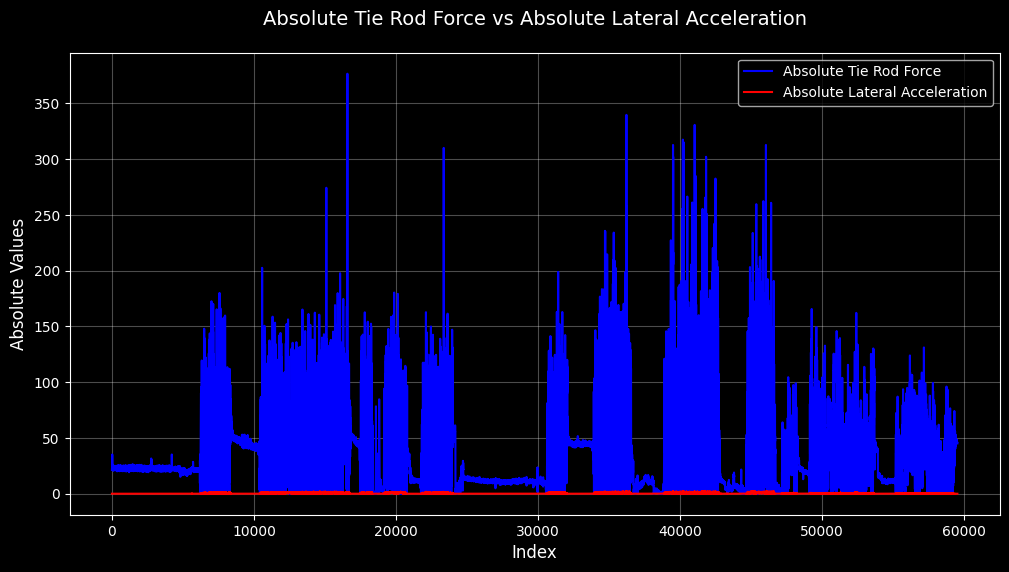

Average Tie Rod Force Peak: 131.95
Average Lateral Acceleration Peak: 1.14 
Number of valid data points: 15917
Correlation coefficient: 0.6047
Maximum tie rod force: 143.39
Minimum tie rod force: -143.35


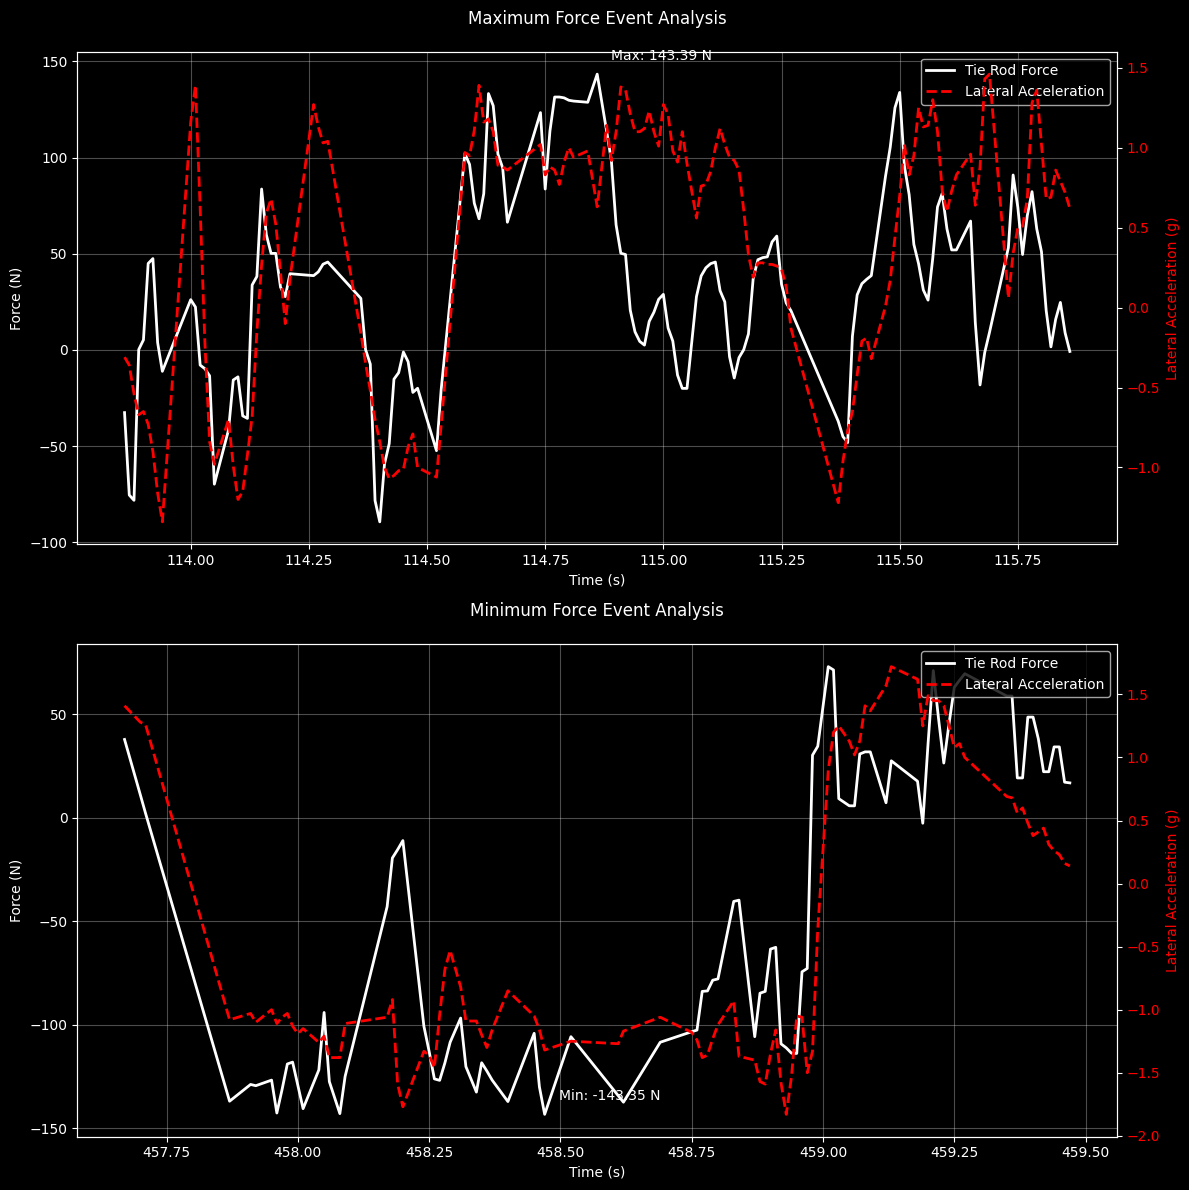

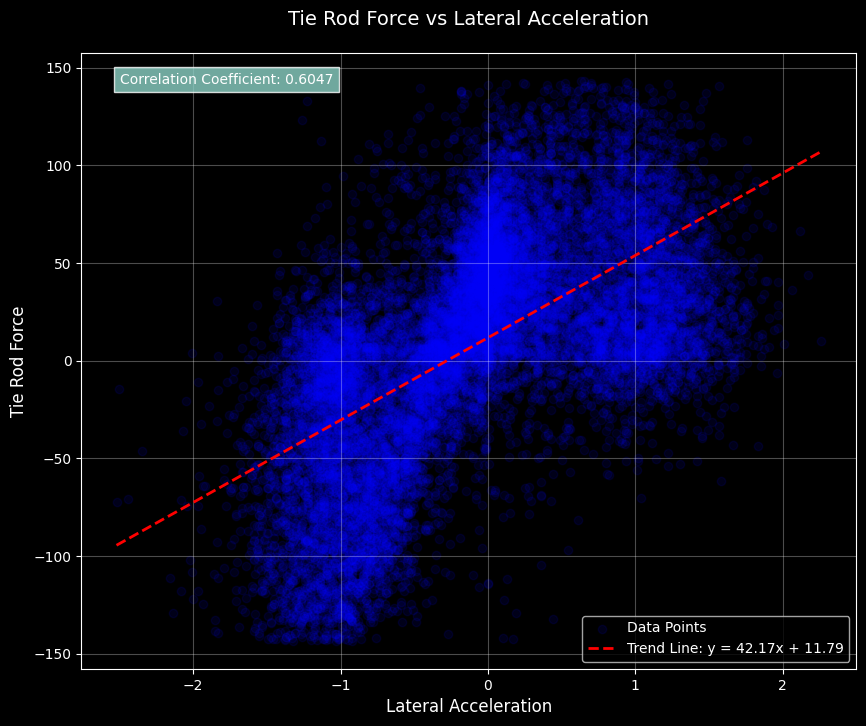

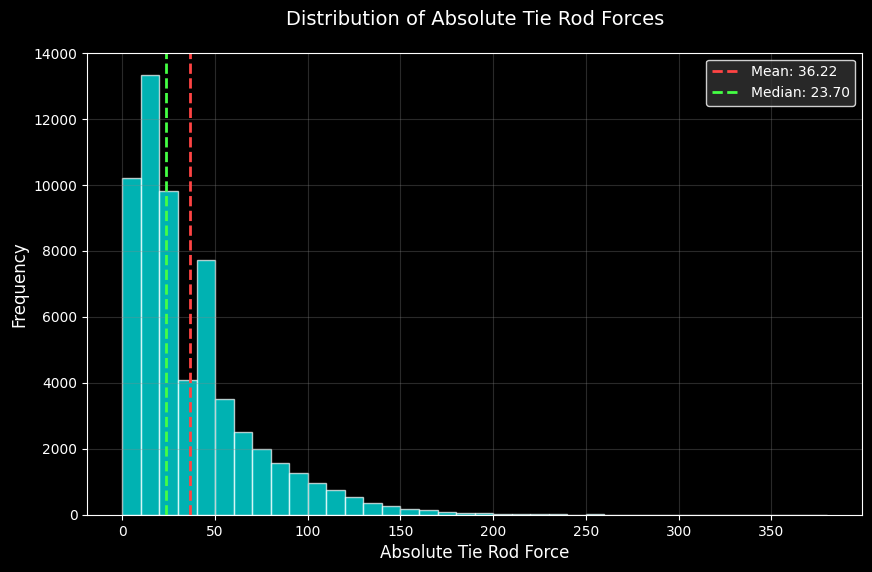

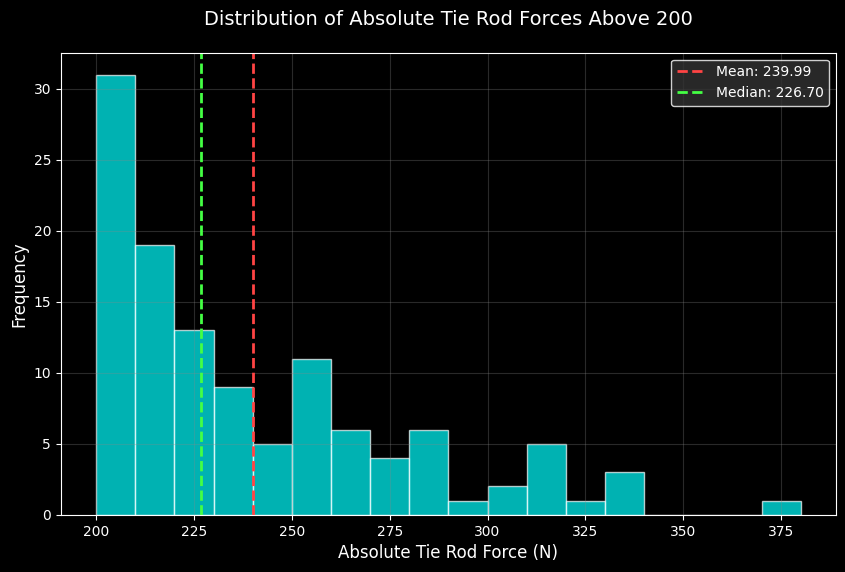

In [560]:
def main():
    df = load_and_clean_data('tie_rod.csv')

    df_normal = pd.read_csv('tie_rod.csv')

    print("Columns in df_normal:", df_normal.columns)

    results = analyze_tie_rod_forces(df,100)

    absolute_forces(df_normal)

    average_peaks(df)

    print(f"Number of valid data points: {len(df)}")
    print(f"Correlation coefficient: {results['correlation']:.4f}")
    print(f"Maximum tie rod force: {results['max_force']:.2f}")
    print(f"Minimum tie rod force: {results['min_force']:.2f}")

    force_analysis(
        results['max_context'],
        results['min_context']

    )
    correlation_plot(
        df,
        results['correlation'],
        results['regression']
    )


    force_histogram(df_normal)

    high_force_histogram(df_normal)

if __name__ == "__main__":
    main()